In [2]:
#update libs
!pip install --upgrade pandas
!pip install --upgrade scikit-learn
!pip install --upgrade inflect
!pip install --upgrade pprint
!pip install --upgrade hyperopt
!pip install --upgrade hpsklearn
!pip install --upgrade seaborn
!pip install --upgrade contractions


Requirement already up-to-date: pandas in c:\anaconda\lib\site-packages (0.23.4)
Requirement already up-to-date: scikit-learn in c:\anaconda\lib\site-packages (0.20.2)
Requirement already up-to-date: inflect in c:\anaconda\lib\site-packages (2.1.0)
Requirement already up-to-date: pprint in c:\anaconda\lib\site-packages (0.1)
Requirement already up-to-date: hyperopt in c:\anaconda\lib\site-packages (0.1.1)
Requirement already up-to-date: hpsklearn in c:\anaconda\lib\site-packages (0.1.0)
Requirement already up-to-date: seaborn in c:\anaconda\lib\site-packages (0.9.0)
Requirement already up-to-date: contractions in c:\anaconda\lib\site-packages (0.0.17)


In [3]:
#import common libs
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
import seaborn as sns

import re
import string
import inflect
import itertools
from pprint import pprint
from tqdm import tqdm
import glob
import contractions

#from scipy import interp
sns.set(font_scale=1.3)

In [59]:
#import special libs
from sklearn.preprocessing import label_binarize,MultiLabelBinarizer
from sklearn.pipeline import make_pipeline,Pipeline

from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.multiclass import OneVsRestClassifier

from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split 
from sklearn.model_selection import KFold,RandomizedSearchCV, cross_val_score

from sklearn.metrics import confusion_matrix, recall_score, brier_score_loss
from sklearn.metrics import f1_score, make_scorer, precision_score
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA, TruncatedSVD,IncrementalPCA

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

from sklearn.calibration import CalibratedClassifierCV, calibration_curve


%matplotlib inline

In [5]:
import nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('names')

from nltk.corpus import names
from nltk.corpus import stopwords
from nltk import ngrams

from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer # one more stemmer? or lemmatisation
from nltk.stem import WordNetLemmatizer,LancasterStemmer

from sklearn.datasets import fetch_20newsgroups
seed = 321

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


Загрузим датасет с классифицируемыми текстами.

In [6]:
# здесь shuffle = true, т.к. мы собираемся использовать SGDClassifier; Naive Bayes - они базируются на принципе iid данных 
#и чтобы не получить смещенную оценку
newsgroups_all = fetch_20newsgroups(subset='all', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))
train_texts = fetch_20newsgroups(subset='train', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))
test_texts = fetch_20newsgroups(subset='test', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))

Итак, задача данной работы:



#### EDA.

Посмотрим на данные, для этого:
- посмотрим на категории текстов
- распределение документов по категориям
- посмотрим на примеры данных

In [7]:
pprint("%d documents" % len(newsgroups_all.data))
pprint("%d categories" % len(newsgroups_all.target_names))

'18846 documents'
'20 categories'


In [8]:
def generate_stat_df(df,df_type):
    unique, counts = np.unique(df.target, return_counts=True)

    df_print = pd.DataFrame(data=list(zip(unique, df.target_names, counts)), 
                            columns = ['Id_category', 'Category_Name', 'N_texts'])
    df_print['High_level_topic'] = df_print["Category_Name"].str.split(".", expand = True)[0]
    df_print['Dataset_Type'] = df_type
    return df_print

df_summary = generate_stat_df(train_texts, 'train')
df_summary = df_summary.append(generate_stat_df(test_texts, 'test'), ignore_index=True)
df_summary = df_summary.append(generate_stat_df(newsgroups_all, 'all'), ignore_index=True)

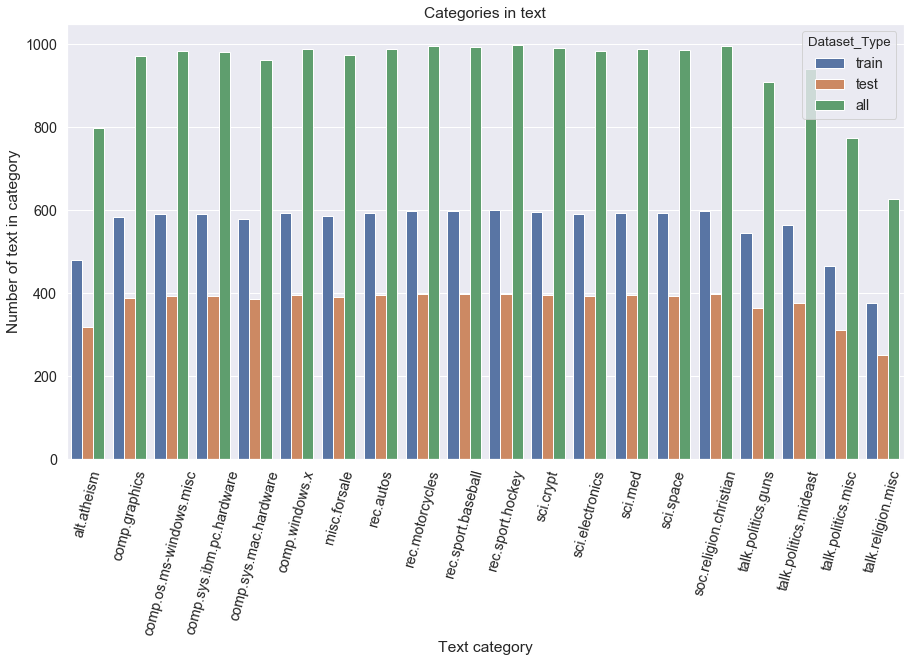

In [9]:
# print the histogramm with distribution of texts by categorieas and topics
plt.figure(figsize=(15,8))
sns.barplot(x="Category_Name", y="N_texts", hue = 'Dataset_Type',data=df_summary)
plt.xticks(rotation=75)
plt.xlabel('Text category');
plt.ylabel('Number of text in category');
plt.title("Categories in text");

                   0     1      2     3     4      5     6     7      8   \
High_level_topic  alt   alt    alt  comp  comp   comp  misc  misc   misc   
Dataset_Type      all  test  train   all  test  train   all  test  train   
N_texts           799   319    480  4891  1955   2936   975   390    585   

                    9   ...       11    12    13     14   15    16     17  \
High_level_topic   rec  ...      rec   sci   sci    sci  soc   soc    soc   
Dataset_Type       all  ...    train   all  test  train  all  test  train   
N_texts           3979  ...     2389  3952  1579   2373  997   398    599   

                    18    19     20  
High_level_topic  talk  talk   talk  
Dataset_Type       all  test  train  
N_texts           3253  1301   1952  

[3 rows x 21 columns]


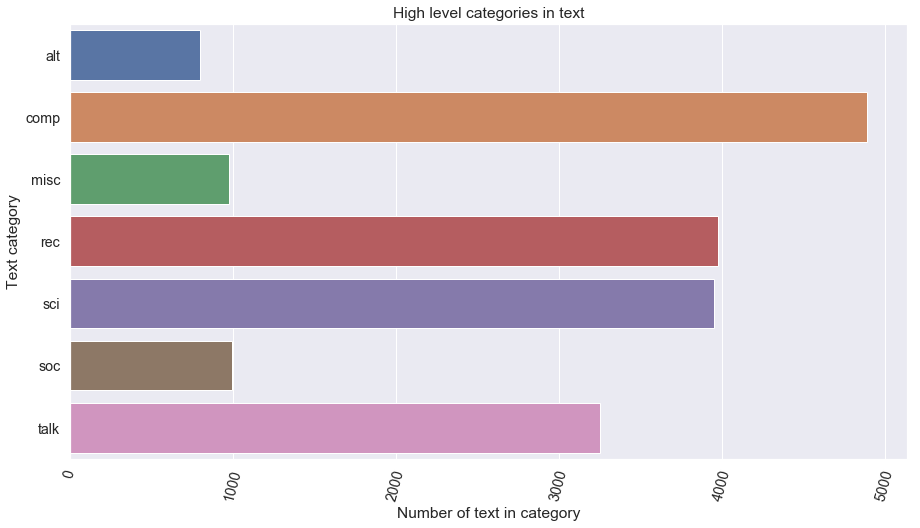

In [10]:
groupped_df = df_summary.groupby(['High_level_topic','Dataset_Type']).agg({'N_texts': ['sum']})
groupped_df.columns = groupped_df.columns.droplevel(1)
groupped_df.reset_index(inplace=True)
print(groupped_df.T)


plt.figure(figsize=(15,8))
sns.barplot(x="N_texts", y="High_level_topic", data=groupped_df[groupped_df.Dataset_Type == 'all'])
plt.xticks(rotation=75)
plt.xlabel('Number of text in category');
plt.ylabel('Text category');
plt.title("High level categories in text");

Посмотрим на образец данных.

In [11]:
pprint(newsgroups_all.data[11])

('\n'
 'This is a ridiculous argument for being a Christian.  So then, you might \n'
 'consider switching from Christianity to another religion if you were \n'
 'offered an even more frightening description of another hell?  How many\n'
 'Christians do think there are who view it strictly as an insurance policy?\n'
 'Not many I know; they believe in a message of love and compassion for \n'
 'others.  A faith based on fear of hell sounds like a dysfunctional \n'
 "relationship with God.  Like a child who cringes in fear of a parent's\n"
 'physical violence.  \n'
 '\n'
 'Many religions have concrete views of heaven and hell, with various\n'
 'threats and persuasions regarding who will go where.  Competition over\n'
 'who can envison the worst hell can hardly nurture the idea of loving\n'
 'your neighbor as yourself.\n'
 '\n')


In [12]:
newsgroups_all.target_names[newsgroups_all.target[11]]

'soc.religion.christian'

Текст содержит элементы вида - перенос строки, знаки препинания, имя собественное.

In [13]:
pprint(newsgroups_all.data[39])

('\n'
 '\n'
 "Again, you missed Jesus's point.  If you read the surrounding passages\n"
 'you would understand what Jesus means by "life in the world."  But\n'
 'as is, you bumbled around, asserted your standard axiom that the Bible is '
 'bunk,\n'
 'and came up with the wrong idea.  Also, you do not know exactly\n'
 'what Jesus means by eternal life.  \n'
 '\n'
 'Brian K., do you expect to jump in the middle of the quantum mechanics\n'
 'book and understand Hermite polynomials having not read the surrounding\n'
 'material?  Why do you such with the Bible?  For an idea what Jesus\n'
 'means by the world, look up references to it in your concordance.  For\n'
 'a good description, the whole Book of Ecclesiastes is game.  For \n'
 'eternal life, check out John 17:3, John 3:15-16.  You will find that\n'
 'eternal life is quite different than what you think.  Eternal life\n'
 'starts NOW--an infinitely high quality of life living in fellowship\n'
 'with God.\n'
 '\n'
 '\n'
 '\n'
 'If my die

In [14]:
newsgroups_all.target_names[newsgroups_all.target[39]]

'talk.religion.misc'

Помимо элементов из предыдущего текста здесь добавились ..., почтовый адрес и другие шумовые "элементы".

#### Data preprocessing.

Предобработаем данные, для этого:
- приведем все слова к нижнему регистру+.
- удалим знаки препинания+.
- заменим представление чисел в виде цифр на текстовые аналоги+.
- отсечем стоп слова (уберем символы и комбинации, которые не составляют смысловой нагрузки)+.
- проведем лемматизацию/стемминг (приведение слова к начальной форме с помощью словаря/выделение корня слова)+.
- удалим слова длиной 2 и менее символов+.
- выделим n-граммы (последовательности из нескольких слов, рассматриваемых как одно целое).

In [15]:
def remove_emails(text):
    text = re.sub('\S*@\S*\s?','',text)
    
    return text

In [16]:
def remove_punctuation2(text_punctuation,text):
    
    new_text = []
    new_text = re.sub('['+text_punctuation+']', ' ',text)
    #new_text = re.sub('\n', ' ',new_text)
    #new_text = re.sub('\t', '',new_text)
    new_text =  new_text.strip()
    
    '''for word in text: 
        new_word =  re.sub('['+text_punctuation+']', ' ',word)
        new_word =  new_word.strip()
        new_text.append(new_word)'''
    
    return new_text


def remove_punctuation(text_punctuation,text):
    
    new_text = []
    #new_text = re.sub('['+text_punctuation+']', '',text)
    #new_text = re.sub('\n', ' ',new_text)
    for word in text: 
        new_word =  re.sub('['+text_punctuation+']', ' ',word)
        new_word =  new_word.strip()
        new_text.append(new_word)
    
    return new_text

In [17]:
def digits_to_text(text):
    p = inflect.engine()
    new_text = []
    for word in text:
        if word.isdigit():
            if len(word) > 18:
                print (1) #do nothing
            else:
                new_word = p.number_to_words(word)
                new_text.append(new_word)
        else:
            new_text.append(word)
    #del p
    return new_text

In [18]:
def lemmatize_stemm_text(text):
    new_text_lemma = []
    new_text_stemm = []
    
    lemmatizer = WordNetLemmatizer()
    stemmer = LancasterStemmer()
    
    for word in text:
        lemma = lemmatizer.lemmatize(word, pos='v') # pay attention to pos='v' parameter!
        new_text_lemma.append(lemma)
        
        stemm = stemmer.stem(word)
        new_text_stemm.append(stemm)
        
    return new_text_lemma, new_text_stemm
        

In [19]:
StopWords = list(set( stopwords.words('english') ).union( set(ENGLISH_STOP_WORDS)))
newStopWords = ['jfc','jb'] # по ходу работы периодически добавляем стоп-слова
newStopWords2 = ['arent', 'didnt', 'doesnt', 'dont', 'hadnt', 'havent', 'isnt', 
                 'mightnt', 'mustnt', 'neednt', 'shant', 'shes', 'shouldnt', 'shouldve', 'theres','thatll', 'wasnt', 
                 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve',
                 "'ll", "'re", "'ve", "n't", 'need', 'sha', 'anna','n t','ann mari', 'ann marie', 
                 'anna diana', 'anna diane', 'anna maria', 'anne corinne', 'anne mar', 'anne marie', 
                 'barbara anne', 'bette ann', 'carol jean', 'diane marie', 'e lane', 'hans peter', 
                 'helen elizabeth', 'holly anne', 'jean christophe', 'jean francois', 'jean lou', 
                 'jean luc', 'jean marc', 'jean paul', 'jean pierre', 'jo anne', 'john david', 'john patrick', 
                 'kara lynn', 'marie ann', 'marie jeanne', 'paula grace', 'sara ann', 
                 'sheila kathryn', 'sue elle', 'terri jo', 'theresa marie', 'zsa',
                 '/       \\','0  w','0  w0','000','0000','000000','00000000', '0000000004',
                 '00000000b', '00000001', '00000001b', '00000010',
                 '00000010b', '00000011', '00000011b', '00000074',
                 '00000100', '00000100b', '00000101', '00000101b',
                 '00000110', '00000110b', '00000111', '00000111b',
                 '000005102000', '00001000', '00001000b',
                 '00001001', '00001001b', '00001010', '00001010b',
                 '00001011', '00001011b', '00001100', '00001100b', '00001101']

StopWords.extend(newStopWords)
StopWords.extend(newStopWords2)


male_names = names.words('male.txt')
female_names = names.words('female.txt')

Common_First_Names = list(set(male_names).union(set(female_names)))
Common_First_Names = list(map(lambda word: word.lower(), Common_First_Names))

#StopWords.extend(Common_First_Names)

def remove_stopwords(stop_words ,text):
    
    new_words = []
    for word in text:
        if word not in stop_words:
            new_words.append(word)

    return new_words

In [20]:
def remove_short_words(text, word_len):
    new_text = []
    for word in text:
        if len(word) >= word_len:
            new_text.append(word)
            
    return new_text

In [21]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

In [22]:
from bs4 import BeautifulSoup
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [23]:
import unicodedata

In [24]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

In [25]:
# getting source from string.punctuation,removed -, :
text_punctuation = '!"#$%&\'()*+,-.:;<=>?@[\\]_`{|}~/^'

def tokenize(text):
    min_length = 3
    
    # remove emails from text to prevent overfit
    text = remove_emails(text)
    
    #remove html 
    text = strip_html(text)
    
    #  text  to lowercase
    text =  text.lower()
    
    # test it
    text = replace_contractions(text)
    
    #remove punctuation
    text = remove_punctuation2(text_punctuation, text) 
    
    #ngrams test
    #words = list(ngrams(text.split(), 3))

    # tokenize text
    words = word_tokenize(text,language='english')
    
    #remove non ascii? test it
    words = remove_non_ascii(words)
    
    #remove punctuation
    #words = remove_punctuation(text_punctuation, words)   
    
    #replace digits with words
    #words = digits_to_text(words)
        
    # remove stopwords
    words = remove_stopwords(StopWords,words)
    
    #lemmatize words 0.69 f1score
    words,_ = lemmatize_stemm_text(words)
    
    #stemm words 
    #_,words = lemmatize_stemm_text(words)
    
    #filter short words
    words = remove_short_words(words, 3)

    return words

In [26]:
'''

sentence = 'this is a foo bar sentences and i want to ngramize it'

n = 3
sixgrams = ngrams(sentence.split(), n)

for grams in sixgrams:
  print (grams)''';

In [27]:
pprint(newsgroups_all.data[10:15]) #1,3,55,39

['From: Center for Policy Research <cpr>\n'
 'Subject: Zionism - racism\n'
 '\n'
 '\n'
 "Diaspora 'a cancer'\n"
 '------------------- by Julian Kossoff and Lindsay Schusman in:\n'
 'Jewish Chronicle, London, 22. Dec. 1989\n'
 '\n'
 'Leading Israeli author and cultural commentator, A.B. Yehoshua,\n'
 'launched a ferocious attack on diaspora Jewry at a Zionist Youth\n'
 'Council meeting in North London, last week.\n'
 '\n'
 'The diaspora, he claimed, "was the cancer connected to the main\n'
 'tissue of the Jewish people". He was scathing about its failure to\n'
 'act before the Holocaust.\n'
 '\n'
 "He said the diaspora's religious and secular leadership had\n"
 'ignored the warning signs in the 1920s, and had fiercely opposed\n'
 'Zionism. Consequently, he considered the Holocaust, "the failure\n'
 'of Judaism".\n'
 '\n'
 'His talk, entitled "Diaspora: A Neurotic Solution", covered 5,000\n'
 'years of Jewish history.\n'
 '\n'
 "Mr. Yehoshua's other targets included Soviet Jews who were,

In [28]:
%%time
test = tokenize(newsgroups_all.data[10])
test4 = tokenize(newsgroups_all.data[44])
test5 = tokenize(newsgroups_all.data[55])
test6 = tokenize(newsgroups_all.data[66])
test7 = tokenize(newsgroups_all.data[77])

Wall time: 2.03 s


In [29]:
test, test4, test6, test7,test5

(['center',
  'policy',
  'research',
  'subject',
  'zionism',
  'racism',
  'diaspora',
  'cancer',
  'julian',
  'kossoff',
  'lindsay',
  'schusman',
  'jewish',
  'chronicle',
  'london',
  'dec',
  '1989',
  'lead',
  'israeli',
  'author',
  'cultural',
  'commentator',
  'yehoshua',
  'launch',
  'ferocious',
  'attack',
  'diaspora',
  'jewry',
  'zionist',
  'youth',
  'council',
  'meet',
  'north',
  'london',
  'week',
  'diaspora',
  'claim',
  'cancer',
  'connect',
  'main',
  'tissue',
  'jewish',
  'people',
  'scathing',
  'failure',
  'act',
  'holocaust',
  'say',
  'diaspora',
  'religious',
  'secular',
  'leadership',
  'ignore',
  'warn',
  'sign',
  '1920s',
  'fiercely',
  'oppose',
  'zionism',
  'consequently',
  'consider',
  'holocaust',
  'failure',
  'judaism',
  'talk',
  'entitle',
  'diaspora',
  'neurotic',
  'solution',
  'cover',
  'years',
  'jewish',
  'history',
  'yehoshua',
  'target',
  'include',
  'soviet',
  'jews',
  'say',
  'stay',
  '

#### Classification. Apriory knoweledge.

После того, как проверили работу токенизатора, извлечем фичи из текста с использованием TF-IDF.

In [30]:
vectorizer = TfidfVectorizer(stop_words=StopWords,
                             tokenizer=tokenize, 
                             #min_df=2, # ignore terms with freq less that 0.05, lower majoring
                             #max_df=0.7, # ignore terms with freq more that n, upper majoring
                             #max_features=55000,
                             use_idf=True,  
                             sublinear_tf=True,
                             norm='l2',
                             ngram_range= (1, 3)
                            )

In [31]:
%%time
vectorised_train_documents = vectorizer.fit_transform(train_texts.data)
vectorised_test_documents = vectorizer.transform(test_texts.data)

C:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ann', 'anne', 'barbara', 'bette', 'carol', 'christophe', 'corinne', 'david', 'diana', 'diane', 'elizabeth', 'elle', 'francois', 'grace', 'hans', 'helen', 'holly', 'jean', 'jeanne', 'john', 'kara', 'kathryn', 'lane', 'lou', 'luc', 'lynn', 'mar', 'marc', 'mari', 'maria', 'marie', 'patrick', 'paul', 'paula', 'peter', 'pierre', 'sara', 'shall', 'sheila', 'sue', 'terri', 'theresa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Anaconda\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Anaconda\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass t

Wall time: 4min 15s


Выделим метки для трейн/тест датасетов.

In [32]:
y_train, y_test = train_texts.target, test_texts.target

Дополним код вспомогательными функциями, которые будет производить:
- построение матрицы классификации.
- обучение и проверку работы классификатора, с заданными параметрами.

In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Paired):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(20,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [34]:
#simple variant
def classify_and_score(classifier, X_train, X_test, y_train, y_test):
    clf = classifier
    clf.fit(X_train, y_train)

    pred_train = clf.predict(X_train)
    #print ("Train score")
    f1_train = f1_score(y_train, pred_train, average='micro')

    #print ("Test score")
    pred_test = clf.predict(X_test)
    f1_test = f1_score(y_test, pred_test, average='micro')
    
    return f1_train, f1_test, clf

Для удобства, результирующие метрики будем сохранять в df.

In [35]:
results_df = []
results_df = pd.DataFrame(columns=('Algorithm', 'Train_score', 'Test_score', 'parameters'))

In [36]:
#variant with pipeline and cv
'''def classify_and_score(classifier, X_train, X_test, y_train, y_test):
    tfidf_params = {
        'stop_words' : StopWords,
        'tokenizer':tokenize,
        'use_idf':True,
        'sublinear_tf':True,
        'norm':'l2'
    }
    clf = Pipeline([('vect', TfidfVectorizer(** tfidf_params)), ('classifier', classifier)])
    
    clf.fit(X_train, y_train)

    pred_train = clf.predict(X_train)
    #print ("Train score")
    f1_train = f1_score(y_train, pred_train, average='micro')

    #print ("Test score")
    #pred_test = clf.predict(X_test)
    #f1_test = f1_score(y_test, pred_test, average='micro')
    
    my_scorer = make_scorer(f1_score, average='weighted')
    skv = StratifiedKFold(n_splits = 3,random_state=seed, shuffle=True)
    f1_test = cross_val_score(clf, X_test, y_test, cv=skv, scoring=my_scorer,n_jobs = -1).mean()
    
    return f1_train, f1_test


alphas = [0.01 , 0.015, 0.02]

for alph in tqdm(alphas):
    a = "MultinomialNB"
    b,c = classify_and_score(MultinomialNB(alpha=alph), train_texts.data, 
                           test_texts.data, y_train, y_test)
    d = "alpha = " + str(alph)

    results_df = results_df.append({'Algorithm':a, 'Train_score':b,'Test_score':c, 'parameters':d},ignore_index=True)
    
    ''';

Проверим работу алгоритмов:
- MultinomialNB

In [37]:
#actual block of code
alphas = [0.0001,0.001,0.005 ,0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
       0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095,
       0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135, 0.14 ,
       0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 , 0.185,
       0.19 , 0.195, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 1.01,2,5]

for alph in tqdm(alphas):
    f_el = "MultinomialNB"
    s_el,t_el,_ = classify_and_score(MultinomialNB(alpha=alph), vectorised_train_documents, 
                           vectorised_test_documents, y_train, y_test)
    f0_el = "alpha = " + str(alph)

    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [02:19<00:00,  2.15s/it]


- BernoulliNB

In [1300]:
for alph in tqdm(alphas):
    f_el = "BernoulliNB"
    s_el,t_el,_ = classify_and_score(BernoulliNB(alpha=alph), vectorised_train_documents, 
                           vectorised_test_documents, y_train, y_test)
    f0_el = "alpha = " + str(alph)

    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score':t_el, 'parameters':f0_el},ignore_index=True)



  0%|                                                                                           | 0/51 [00:00<?, ?it/s]

  2%|█▋                                                                                 | 1/51 [00:00<00:10,  4.69it/s]

  4%|███▎                                                                               | 2/51 [00:00<00:10,  4.73it/s]

  6%|████▉                                                                              | 3/51 [00:00<00:09,  4.96it/s]

  8%|██████▌                                                                            | 4/51 [00:00<00:09,  5.14it/s]

 10%|████████▏                                                                          | 5/51 [00:00<00:08,  5.26it/s]

 12%|█████████▊                                                                         | 6/51 [00:01<00:08,  5.33it/s]

 14%|███████████▍                                                                       | 7/51 [00:01<00:08,  5.36it/s]

 16%|█████████████            

Выведем наилучший достигнутый результат.

In [38]:
best_param = results_df[results_df.Test_score ==  results_df.Test_score.max()]['parameters'].values[0]
print (results_df[results_df.Test_score ==  results_df.Test_score.max()])

'''
6    MultinomialNB     0.951741       0.687865  alpha = 0.025
304  MultinomialNB     0.970479       0.687865  alpha = 0.015
16  MultinomialNB     0.938041    0.695035  alpha = 0.075 without two new functions
8  MultinomialNB     0.944317    0.696893  alpha = 0.035 45000 features
7  MultinomialNB      0.94741    0.697424  alpha = 0.03 55000 features
15  MultinomialNB     0.947941    0.695698   alpha = 0.07 # ngrams 1,3 and 55000 features
4  MultinomialNB     0.970656    0.701275  alpha = 0.015 # with ngrams but without max features

''';

       Algorithm  Train_score  Test_score     parameters
4  MultinomialNB     0.970656    0.701275  alpha = 0.015


Для проверки результатов выведем classification_report и построим матрицу классификации.

                          precision    recall  f1-score   support

             alt.atheism       0.75      0.34      0.47       319
           comp.graphics       0.69      0.69      0.69       389
 comp.os.ms-windows.misc       0.70      0.55      0.62       394
comp.sys.ibm.pc.hardware       0.64      0.71      0.67       392
   comp.sys.mac.hardware       0.76      0.67      0.71       385
          comp.windows.x       0.77      0.78      0.77       395
            misc.forsale       0.79      0.76      0.78       390
               rec.autos       0.84      0.72      0.77       396
         rec.motorcycles       0.80      0.74      0.77       398
      rec.sport.baseball       0.93      0.81      0.86       397
        rec.sport.hockey       0.59      0.93      0.72       399
               sci.crypt       0.66      0.80      0.73       396
         sci.electronics       0.75      0.58      0.66       393
                 sci.med       0.81      0.77      0.79       396
         

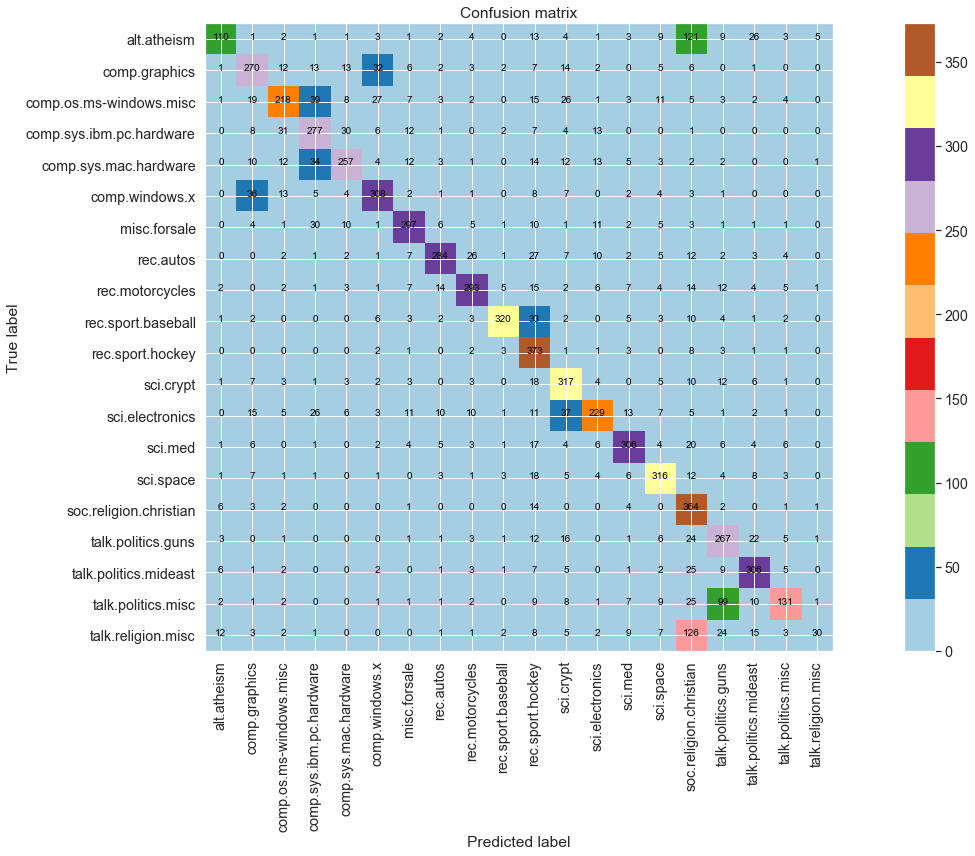

In [39]:
_,_,clf =  classify_and_score(MultinomialNB(alpha = 0.03), vectorised_train_documents, 
                                        vectorised_test_documents, y_train, y_test)

pred_test = clf.predict(vectorised_test_documents)
print(classification_report(y_test,pred_test,target_names = newsgroups_all.target_names))

cnf_matrix = confusion_matrix(y_test, pred_test)
print(plot_confusion_matrix(cnf_matrix, classes = newsgroups_all.target_names))


In [1715]:
len(vectorizer.get_feature_names())

1604550

In [1716]:
len(clf.coef_[0])

1604550

In [1913]:
#sorted(clf.coef_[0],reverse=True)[:10]

print(np.take(vectorizer.get_feature_names(), sorted(clf.coef_[0, :],reverse=True)[:10]))

['00000 11888 22623' '00000 11888 22623' '00000 11888 22623' '00000 11888'
 '00000 11888' '00000 11888' '00000 11888' '00000 11888' '00000 11888'
 '00000 11888']


In [1729]:
# improve for most not used words too
for cls in range(len(clf.coef_)):
    print (cls)
    print (newsgroups_all.target_names[cls])
    neg_class_prob_sorted = clf.coef_[cls, :].argsort()
    print(np.take(vectorizer.get_feature_names(), neg_class_prob_sorted[:10]))

0
alt.atheism
['christ' 'christians' 'want' 'scripture' 'christian' 'sin' 'heaven'
 'israel' 'use' 'children']
1
comp.graphics
['drive' 'people' 'key' 'monitor' 'window' 'windows' 'widget' 'disk'
 'make' 'sale']
2
comp.os.ms-windows.misc
['comp windows' 'comp' 'image' 'board' 'bite' 'x11r5' 'server' 'power'
 'motif' 'graphics']
3
comp.sys.ibm.pc.hardware
['mac' 'apple' 'latest' 'car' 'sun' 'sale' 'brand new' 'include' 'code'
 'items']
4
comp.sys.mac.hardware
['windows' 'controller' 'ide' 'car' 'bios' 'offer' 'file' 'gateway'
 'condition' '486']
5
comp.windows.x
['mac' 'card' 'post' 'vga' 'drive' 'disk' 'computer' 'apple' 'monitor'
 'power']
6
misc.forsale
['help' 'think' 'know' 'appreciate' 'tell' 'read' 'sell sign' 'problem'
 'try' 'mac']
7
rec.autos
['bike' 'card' 'game' 'use' 'program' 'file' 'gun' 'work' 'board' 'apple']
8
rec.motorcycles
['use' 'believe' 'game' 'government' 'power' 'key' 'team' 'space' 'card'
 'problem']
9
rec.sport.baseball
['hockey' 'nhl' 'leaf' 'playoffs' 'ice'

In [1734]:
def show_most_informative_features(vectorizer, clf, n=20):
    aa = []
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[19], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        aa.append(fn_1)
        
    return aa

In [1735]:
aa = show_most_informative_features(vectorizer, clf, n = 30)

	-0.4506	able           		1.7959	koresh         
	-0.4477	thank          		1.5835	kent           
	-0.4299	right          		1.4974	christian      
	-0.4231	year           		1.4440	critus         
	-0.4130	best           		1.4424	lunacy         
	-0.3874	problem        		1.4419	cockroaches    
	-0.3858	idea           		1.3246	jesus          
	-0.3847	claim objective		1.1533	objective      
	-0.3803	atheist        		1.0925	morality       
	-0.3706	use            		1.0891	rosicrucian    
	-0.3610	stuff delete   		1.0865	christians     
	-0.3605	work           		1.0703	amorc          
	-0.3472	resurrection   		1.0678	cheer kent     
	-0.3470	drive          		1.0022	ignorance strength
	-0.3452	information    		0.9603	ignorance      
	-0.3321	space          		0.9571	objective morality
	-0.3238	file           		0.9204	commandment    
	-0.3197	university     		0.9136	thou           
	-0.3168	course         		0.9124	god            
	-0.3136	jam            		0.9006	fbi            
	-0.3089	new  

- LinearSVC

#what if l1,l2 or ...loss?

In [120]:
%%time
C_values = [ 0.05, 0.1, 0.15 ,0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 2.0, 5.0, 10.0, 20.0]

for c in C_values:
    f_el = "LinearSVC"
    s_el,t_el,_ = classify_and_score(LinearSVC(C=c,random_state=seed,max_iter = 10e3,class_weight = 'balanced'), 
                                   vectorised_train_documents, 
                           vectorised_test_documents, y_train, y_test)
    f0_el = "C = " + str(c)

    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

- SVC Kernel Poly

In [128]:
%%time
C_values = [ 0.05, 0.1, 0.15 ,0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 2.0, 5.0, 10.0, 20.0, 40.0, 60.0, 100.0]

for c in tqdm(C_values):
    f_el = "SVC_poly"
    s_el,t_el,_ = classify_and_score(SVC(kernel='poly',gamma='scale',C=c,random_state=seed,class_weight = 'balanced'), 
                                   vectorised_train_documents, vectorised_test_documents, y_train, y_test)
    f0_el = "C = " + str(c)

    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:12<00:00, 138.94s/it]


- SVC Kernel Sigmoid and RBF

In [ ]:
kernel = ['rbf','sigmoid']
C_values = [ 0.05, 0.1, 0.15 ,0.2, 0.4, 0.5,  0.8, 1.0, 2.0, 5.0, 10.0]

for kern in tqdm(kernels):
    for c in tqdm(C_values):
        f_el = "SVC_" + kern
        s_el,t_el,_ = classify_and_score(SVC(kernel=kern,gamma='scale',C=c,random_state=seed,class_weight = 'balanced'), 
                                       vectorised_train_documents, vectorised_test_documents, y_train, y_test)
        f0_el = "C = " + str(c) + " Kernel = " + kern

        results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                        'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

In [190]:
results_df[results_df.Test_score ==  results_df.Test_score.max()]

,Algorithm,Train_score,Test_score_cv,parameters
29,MultinomialNB,0.948619,0.673413,alpha = 0.07


In [242]:
results_df.to_csv("results_df.csv", sep=';', encoding='utf-8',index = False, header = True)

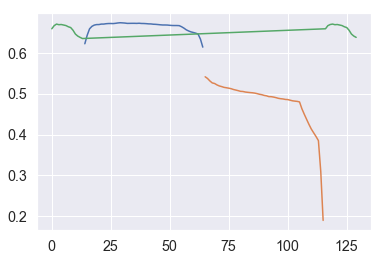

In [240]:
#sns.lineplot(x=results_df.Test_score, hue="Algorithm", lw=1, data=results_df)
#ax = sns.lineplot(y = 'Test_score',data = results_df)
#sns.lineplot(x = results_df.Test_score,data = results_df)
#plt.plot(results_df[results_df.Algorithm == 'SVC_poly']['Test_score'])

In [1479]:
#drop svc results
results_df = results_df[results_df.Algorithm !='SGD']

In [1720]:
sgd_clf = SGDClassifier(loss = 'modified_huber', penalty = 'elasticnet',
                        alpha = 0.0001, l1_ratio = 0.01,
                        max_iter = 1000, tol = 1e-4,
                        n_jobs = -1, random_state = seed,
                        learning_rate = 'optimal', #adaptive - no profit
                        class_weight = 'balanced', shuffle = True,
                        n_iter_no_change = 100, early_stopping = True
             )

In [1721]:
losses = ['hinge','log','modified_huber','squared_hinge','perceptron']
penalties = ['l1','l2','elasticnet']
alphas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 3 , 5]
l1_ratios = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]

for ls in tqdm(losses):
    f_el = "SGD"
    sgd_clf.loss = ls
    s_el,t_el,_ = classify_and_score(sgd_clf, vectorised_train_documents, 
                                     vectorised_test_documents, y_train, y_test)
    f0_el = "loss = " + ls
    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score':t_el, 'parameters':f0_el},ignore_index=True)
'''for alp in tqdm(alphas):
    for l1 in tqdm(l1_ratios):
        f_el = "SGD"
        sgd_clf.alpha = alp
        sgd_clf.l1_ratio = l1
        s_el,t_el,_ = classify_and_score(sgd_clf, vectorised_train_documents, 
                                         vectorised_test_documents, y_train, y_test)
        f0_el = "alpha = " + str(alp) + " l1_ratio = " + str(l1)
        results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                        'Test_score':t_el, 'parameters':f0_el},ignore_index=True)
''';

# compare hinge loss == linear SVM
# compare other different kernels



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 20%|████████████████▊                                                                   | 1/5 [01:13<04:55, 73.93s/it]

 40%|█████████████████████████████████▌                                                  | 2/5 [02:51<04:03, 81.07s/it]

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [04:51<03:05, 92.80s/it]

 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [07:01<01:43, 103.86s/it]

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [08:38<00:00, 101.73s/it]



In [1722]:
results_df.tail()

,Algorithm,Train_score,Test_score,parameters
51,SGD,0.949708,0.696495,loss = hinge
52,SGD,0.936716,0.669145,loss = log
53,SGD,0.951388,0.697823,loss = modified_huber
54,SGD,0.951388,0.697690,loss = squared_hinge
55,SGD,0.935036,0.602629,loss = perceptron


In [1723]:
sgd_clf.loss = 'modified_huber'
#alpha = 0.0001 l1_ratio = 0.01

In [1724]:
sgd_clf

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.01, learning_rate='optimal', loss='modified_huber',
       max_iter=1000, n_iter=None, n_iter_no_change=100, n_jobs=-1,
       penalty='elasticnet', power_t=0.5, random_state=321, shuffle=True,
       tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)

                          precision    recall  f1-score   support

             alt.atheism       0.54      0.45      0.49       319
           comp.graphics       0.68      0.68      0.68       389
 comp.os.ms-windows.misc       0.65      0.62      0.63       394
comp.sys.ibm.pc.hardware       0.67      0.66      0.66       392
   comp.sys.mac.hardware       0.70      0.68      0.69       385
          comp.windows.x       0.80      0.76      0.78       395
            misc.forsale       0.71      0.79      0.75       390
               rec.autos       0.78      0.71      0.74       396
         rec.motorcycles       0.84      0.71      0.77       398
      rec.sport.baseball       0.54      0.84      0.66       397
        rec.sport.hockey       0.87      0.90      0.88       399
               sci.crypt       0.81      0.74      0.77       396
         sci.electronics       0.67      0.59      0.63       393
                 sci.med       0.81      0.80      0.80       396
         

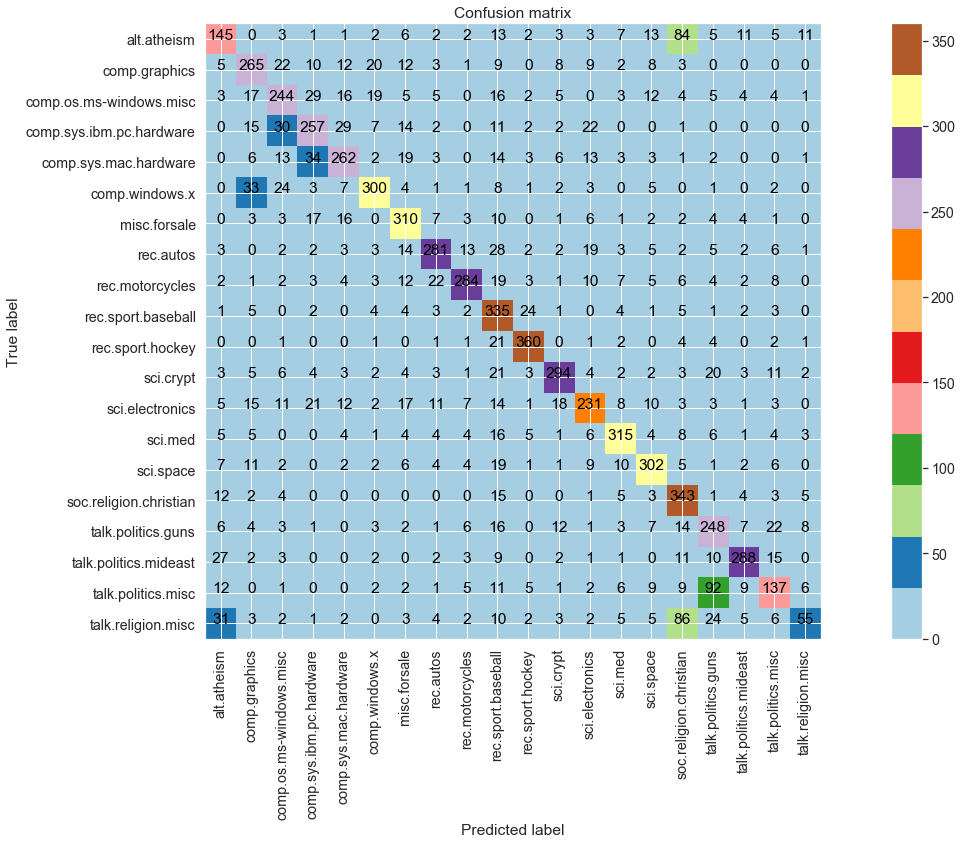

In [1728]:
_,_,clf =  classify_and_score(sgd_clf, vectorised_train_documents, 
                                        vectorised_test_documents, y_train, y_test)

pred_test = clf.predict(vectorised_test_documents)
print(classification_report(y_test,pred_test,target_names = newsgroups_all.target_names))

cnf_matrix = confusion_matrix(y_test, pred_test)
print(plot_confusion_matrix(cnf_matrix, classes = newsgroups_all.target_names))


GaussianNB не использовался, т.к. на вход этому алгоритму требуется dense, а не sparce-матрица.
При выполнении преобразования todense()/toarray() потребление памяти существенно возросло и привело к тому, что массив не помещяется в память.

In [ ]:
"""clf = GaussianNB()
clf.fit(vectorised_train_documents.toarray(), y_train)
pred = clf.predict(vectorised_test_documents.toarray())
f1_score(y_test, pred, average='micro')""";

#### Classfication. Without apriory knoweledge.

Your task is to cluster news without prior knowing of original labels. 
And then evaluate performance of your clustering approach: 
1) using original labels 
2) without prior knowledge of labels.

You also may use dimension reduction techniques for visualization purposes, which can give you some insights about data structure.

Scoring:

1) EDA - 2

Text length histogram, words cloud, whatever...
Dimension reduction and visualization
TruncatedSVD
T-SNE or UMAP.

2) Clustering - 3

K-means or MiniBatchKMeans
DBSCAN or HDBSCANС.

3) Performance evaluation -2.

With prior knowledge of ground truth
At least V-measure and adjusted mutual information

Without prior knowledge of ground truth
At least silhouette coefficient
4) Topic modeling - 2

Understand what's the difference between clustering, dimension reduction and topic modeling
Try to use LDA Ссылки на внешний сайт.from Gensim and pyLDAvisСсылки на внешний сайт. for visualization

В этом разделе попробуем классифицировать объекты без знания о принадлежности текстов к какому-либо классу.
Для этого:
- попробуем посмотреть на тексты без знания(EDA), об их принадлежности классам.
- сократим размерность (TruncatedSVD)  и попробуем визуализировать структуру данных (T-SNE or UMAP).  
- Попробуем выделить классы при помощи K-means or MiniBatchKMeans;DBSCAN or HDBSCANС.

#### EDA.
Для того, чтобы оценить как-то текст, без знания меток классов:
- посчитаем общее количество текстов, построим гистограмму длин текстов, boxplot'ы длин текстов.
- сколько слов во всех текстах, среднее число слов на 1 текст.
- выделим топ-20 слов по всем текстам и построим их гистограмму частот.
- Облако слов?


http://rstudio-pubs-static.s3.amazonaws.com/206183_aa3b2e5280ab4cde910612ae44a3a78a.html
- построим гистограмму: количество слов - длина слова
- Еще график из работы


- посчитаем общее количество текстов, построим гистограмму длин текстов, boxplot'ы длин текстов.

In [40]:
print (len(train_texts.data),';',len(test_texts.data))

11314 ; 7532


In [41]:
len(train_texts.data[0].split())

33

In [42]:
df_texts = pd.DataFrame(data=train_texts.data,columns = ['text'])#, 'text_type'])

df_texts['text_type'] = 'train'

df_texts = df_texts.append(pd.DataFrame(data=test_texts.data,columns = ['text']), ignore_index=True,sort=False)

df_texts.fillna(value='test',inplace=True)

df_texts['text_len'] = df_texts.text.str.len()

df_texts['n_words'] = df_texts.text.str.split()

df_texts['n_words'] = df_texts.n_words.str.len()

#df_texts.head()

print (pd.concat([df_texts[df_texts.text_type == 'train'].describe(),
                  df_texts[df_texts.text_type == 'test'].describe()], axis=1))

# count words in train
df_texts[df_texts.text_type == 'train'].n_words.sum()
# count words in test
df_texts[df_texts.text_type == 'test'].n_words.sum()

           text_len       n_words       text_len      n_words
count  11314.000000  11314.000000    7532.000000  7532.000000
mean    1218.135496    185.827382    1096.862586   175.344397
std     4038.256477    523.971647    3571.221784   465.226887
min        0.000000      0.000000       0.000000     0.000000
25%      237.000000     40.000000     230.000000    39.000000
50%      491.000000     83.000000     483.500000    82.000000
75%      984.750000    167.000000     967.250000   163.000000
max    74878.000000  11765.000000  158791.000000  9507.000000


1320694

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


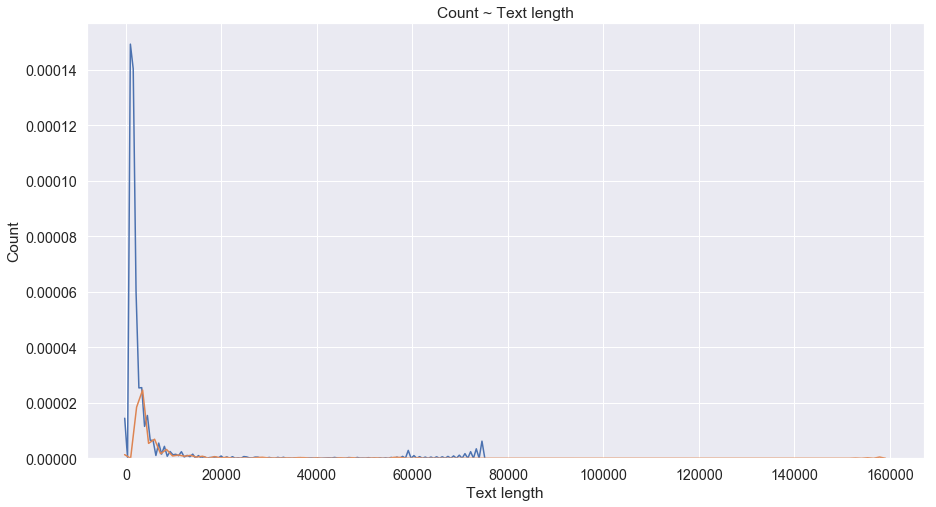

In [43]:
plt.figure(figsize=(15,8))
sns.distplot(df_texts[df_texts.text_type == 'train'].text_len,hist = False)
sns.distplot(df_texts[df_texts.text_type == 'test'].text_len,hist = False)
plt.xlabel('Text length');
plt.ylabel('Count');
plt.title("Count ~ Text length");

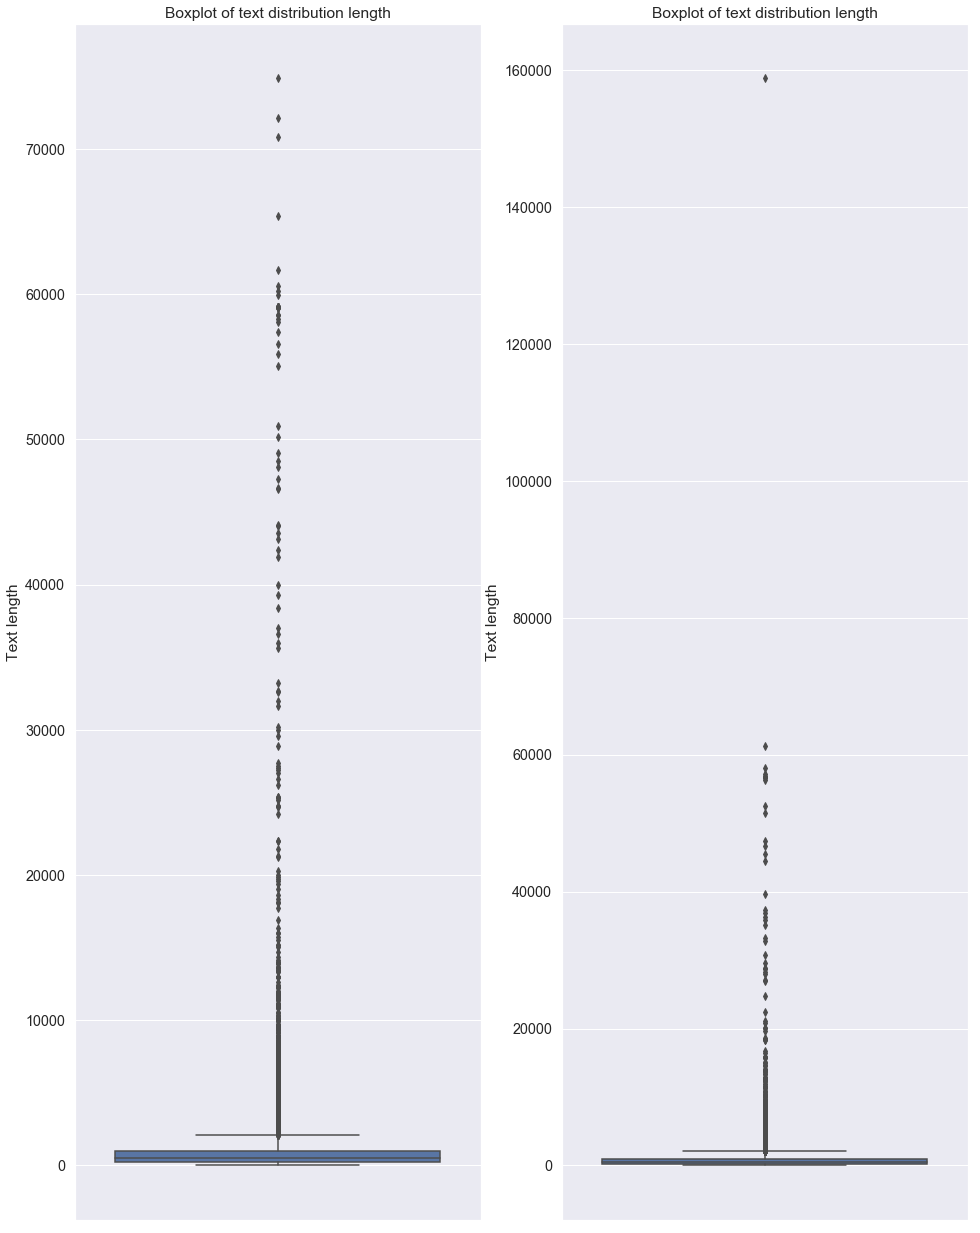

In [44]:
plt.figure(figsize=(16,22))
plt.subplot(1,2,1)
sns.boxplot(y = df_texts[df_texts.text_type == 'train'].text_len)
plt.ylabel('Text length');
plt.title("Boxplot of text distribution length");
plt.subplot(1,2,2)
sns.boxplot(y = df_texts[df_texts.text_type == 'test'].text_len)
plt.ylabel('Text length');
plt.title("Boxplot of text distribution length");
plt.show();

- Выделим топ-20 слов по всем текстам и построим их гистограмму частот.

Считаем через count_vectorizer, потому что то to_array c tf-idf падает с memory error.

In [62]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    
    get_top_n_words(["I love Python", "Python is a language programming", "Hello world", "I love the world"]) -> 
    [('python', 2),
     ('world', 2),
     ('love', 2),
     ('hello', 1),
     ('is', 1),
     ('programming', 1),
     ('the', 1),
     ('language', 1)]
    """
    vec = CountVectorizer(tokenizer=tokenize, 
                          stop_words=StopWords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [89]:
%%time
train_top_words = get_top_n_words(train_texts.data, n=50);
test_top_words = get_top_n_words(test_texts.data, n=50);

C:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ann', 'anne', 'barbara', 'bette', 'carol', 'christophe', 'corinne', 'david', 'diana', 'diane', 'elizabeth', 'elle', 'francois', 'grace', 'hans', 'helen', 'holly', 'jean', 'jeanne', 'john', 'kara', 'kathryn', 'lane', 'lou', 'luc', 'lynn', 'mar', 'marc', 'mari', 'maria', 'marie', 'patrick', 'paul', 'paula', 'peter', 'pierre', 'sara', 'shall', 'sheila', 'sue', 'terri', 'theresa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Anaconda\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Anaconda\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass t

Wall time: 6min 30s


In [2]:
xs_train = [i[0] for i in train_top_words]
ys_train = [i[1] for i in train_top_words]

xs_test = [i[0] for i in test_top_words]
ys_test = [i[1] for i in test_top_words]




plt.figure(figsize=(25,20))
plt.subplot(2,1,1)
sns.barplot(x = xs_train, y = ys_train)
plt.ylabel('Words count');
plt.title("Words frequency histogram");
plt.xticks(rotation=75,fontsize = 18)
plt.subplots_adjust(hspace=0.3)
plt.subplot(2,1,2)
sns.barplot(x = xs_test, y = ys_test)
plt.ylabel('Words count');
plt.xticks(rotation=75,fontsize = 18)
plt.show();

NameError: name 'train_top_words' is not defined

In [47]:
'''#ss = vectorizer.vocabulary_
word2tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

for word, score in word2tfidf.items():
    print(word, score)''';

['00000',
 '00000 11888',
 '00000 11888 22623',
 '00000 12649',
 '00000 12649 230',
 '00000 25599',
 '00000 25599 249',
 '00000 396',
 '00000 396 00800',
 '00000093',
 '00000093 000010af',
 '00000093 000010af test',
 '000000e5',
 '000000e5 00000ee5',
 '000000e5 00000ee5 simple',
 '00000510200001',
 '00000510200001 user',
 '00000510200001 user guest',
 '00000ee5',
 '00000ee5 simple',
 '00000ee5 simple test',
 '000010af',
 '000010af test',
 '000010af test main',
 '00001101b',
 '00001101b 00001110',
 '00001101b 00001110 00001111b',
 '00001101b 00001110b',
 '00001101b 00001110b 00001110',
 '00001110',
 '00001110 00001111b',
 '00001110 00001111b 00001111',
 '00001110b',
 '00001110b 00001101b',
 '00001110b 00001101b 00001110',
 '00001110b 00001110',
 '00001110b 00001110 00001111b',
 '00001111',
 '00001111 00010000b',
 '00001111 00010000b 00010000',
 '00001111 00100000b',
 '00001111 00100000b 00010000',
 '00001111b',
 '00001111b 00001111',
 '00001111b 00001111 00010000b',
 '00001111b 00001111

Words cloud.

In [116]:
!pip install --upgrade wordcloud

In [124]:
vectorizer.vocabulary_

{'shadow': 1286370,
 'come': 316619,
 'close': 305964,
 'block': 216331,
 'sunlight': 1380126,
 'hit': 668703,
 'expect': 519191,
 'view': 1521184,
 'miss': 916787,
 'shadow come': 1286385,
 'come close': 317139,
 'close block': 306070,
 'block sunlight': 216749,
 'sunlight hit': 1380133,
 'hit expect': 668927,
 'expect block': 519279,
 'block view': 216784,
 'view miss': 1521708,
 'shadow come close': 1286386,
 'come close block': 317145,
 'close block sunlight': 306071,
 'block sunlight hit': 216750,
 'sunlight hit expect': 1380134,
 'hit expect block': 668928,
 'expect block view': 519280,
 'block view miss': 216785,
 'position': 1079504,
 'mike': 908743,
 'lansing': 789253,
 'play': 1064209,
 'thank': 1419511,
 'position mike': 1079942,
 'mike lansing': 908896,
 'lansing play': 789256,
 'play thank': 1065562,
 'position mike lansing': 1079943,
 'mike lansing play': 908897,
 'lansing play thank': 789257,
 'drive': 460464,
 'cincinnati': 294074,
 'look': 840745,
 'pretty': 1098292,
 

In [ ]:
from wordcloud import WordCloud

# Combine all reviews for the desired sentiment
#combined_text = " ".join([wd for wd in words])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50,
        stopwords = StopWords)

# Generate and plot wordcloud
plt.figure(figsize =[32,32])
plt.imshow(wc.generate_from_frequencies(vectorizer.vocabulary_))
plt.axis('off')
plt.show()

In [1451]:
from sklearn.cluster import KMeans


In [1736]:
k_clusters = 20 # Number of Centroids we want.
model = KMeans(n_clusters=k_clusters, max_iter=100, n_init=1,n_jobs=-1)
model.fit(vectorised_train_documents)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=20, n_init=1, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [1738]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(k_clusters):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print


'''print("\n")
print("Prediction")
Y = vectorizer.transform(["This Motorbike has the best chain"])# Enter phrase to predict
prediction = model.predict(Y)
print(prediction)
Y = vectorizer.transform(["Turkey is close to Israel"])
prediction = model.predict(Y)
print(prediction)''';




Top terms per cluster:
Cluster 0:
 torment
 thessalonians
 eternal
 destruction
 second death
 understand way
 everlasting
 eternity thessalonians
 burn sulfur
 thessalonians talk
Cluster 1:
 post orwell 1984
 new world sorry
 huxley brave
 huxley brave new
 tarl neustaedter kindly
 neustaedter kindly let
 neustaedter kindly
 1984 probably
 reference prior post
 thank tarl
Cluster 2:
 viola
 valentine
 boston
 leave hand
 say boston win
 gee know valentine
 gee know
 viola sign
 boston bring world
 boston bring
Cluster 3:
 flyers
 puppa
 recchi
 lindros
 soderstrom
 power play
 leaf
 brindour
 bowen
 hawgood
Cluster 4:
 mom
 mozumder april 1993
 men bobby mozumder
 men bobby
 bobby mozumder april
 mozumder april
 virile men bobby
 men
 relate navy men
 say mom
Cluster 5:
 bike
 insurance
 motorcycle
 safety foundation rider
 luck rid motorcycle
 course break insurance
 luck rid
 bike insurance company
 break insurance
 break insurance teach
Cluster 6:
 gun
 abuse goverment
 cars kill
 